## Cats or Dogs

The original Kaggle Classification Challenge can be found [here](https://www.kaggle.com/c/dogs-vs-cats). For more information on useful CNN patterns read [this](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification) notebook. 

In [1]:
import os

DATA_DIR = "/Users/rakesh.karanth/DeepLearning/TensorFlowInPractice/dataset/cats_or_dogs/"
TRAINING_DATA_DIR = os.path.join(DATA_DIR, "train")
TEST_DATA_DIR = os.path.join(DATA_DIR, "test")

## Prepare training and validation data

In [2]:
import pandas as pd

string_labels = []   # To store image labels as string ("cat" or "dog")
integer_labels = []  # To store image labels as integer ("dog" == 1 and "cat" == 0)

image_names = os.listdir(TRAINING_DATA_DIR)
for image_name in image_names:
    animal = image_name.split('.')[0]
    if animal == "dog":
        string_labels.append("dog")
        integer_labels.append(1)
    else:
        string_labels.append("cat")
        integer_labels.append(0)

df = pd.DataFrame({
    'image_name' : image_names,
    'string_label' : string_labels,
    'integer_label' : integer_labels
})

### Get input examples count

In [3]:
df.count()

image_name       25000
string_label     25000
integer_label    25000
dtype: int64

### Look at the input dataframe head and tail

In [4]:
df.head()

,image_name,string_label,integer_label
0,dog.8011.jpg,dog,1
1,cat.5077.jpg,cat,0
2,dog.7322.jpg,dog,1
3,cat.2718.jpg,cat,0
4,cat.10151.jpg,cat,0


In [5]:
df.tail()

,image_name,string_label,integer_label
24995,dog.8008.jpg,dog,1
24996,dog.1992.jpg,dog,1
24997,dog.12412.jpg,dog,1
24998,cat.2701.jpg,cat,0
24999,cat.10148.jpg,cat,0


### Generate training and validation data from the input

Use the validation data if you need to tune model parameters

In [6]:
from sklearn.model_selection import train_test_split

# Use a psuedo random number generator as we always want to get the same examples for training and validation
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset row indices. Do not add the old index as a column in the dataframe
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# Get the training image names (Used later for visualization)
train_image_names = train_df["image_name"].tolist()

### Get training examples count

In [7]:
train_df.count()

image_name       20000
string_label     20000
integer_label    20000
dtype: int64

### Look at the train dataframe head and tail

In [8]:
train_df.head()

,image_name,string_label,integer_label
0,cat.11282.jpg,cat,0
1,cat.7693.jpg,cat,0
2,cat.4977.jpg,cat,0
3,dog.9403.jpg,dog,1
4,cat.10150.jpg,cat,0


In [9]:
train_df.tail()

,image_name,string_label,integer_label
19995,dog.2721.jpg,dog,1
19996,dog.3974.jpg,dog,1
19997,dog.10427.jpg,dog,1
19998,cat.731.jpg,cat,0
19999,dog.6540.jpg,dog,1


### Get validation examples count

In [10]:
validate_df.count()

image_name       5000
string_label     5000
integer_label    5000
dtype: int64

### Look at the validation dataframe head and tail

In [11]:
validate_df.head()

,image_name,string_label,integer_label
0,cat.1474.jpg,cat,0
1,dog.11287.jpg,dog,1
2,dog.8276.jpg,dog,1
3,cat.7227.jpg,cat,0
4,cat.2997.jpg,cat,0


In [12]:
validate_df.tail()

,image_name,string_label,integer_label
4995,cat.7991.jpg,cat,0
4996,dog.9208.jpg,dog,1
4997,cat.5676.jpg,cat,0
4998,cat.9901.jpg,cat,0
4999,dog.9535.jpg,dog,1


## Visualize a few training images

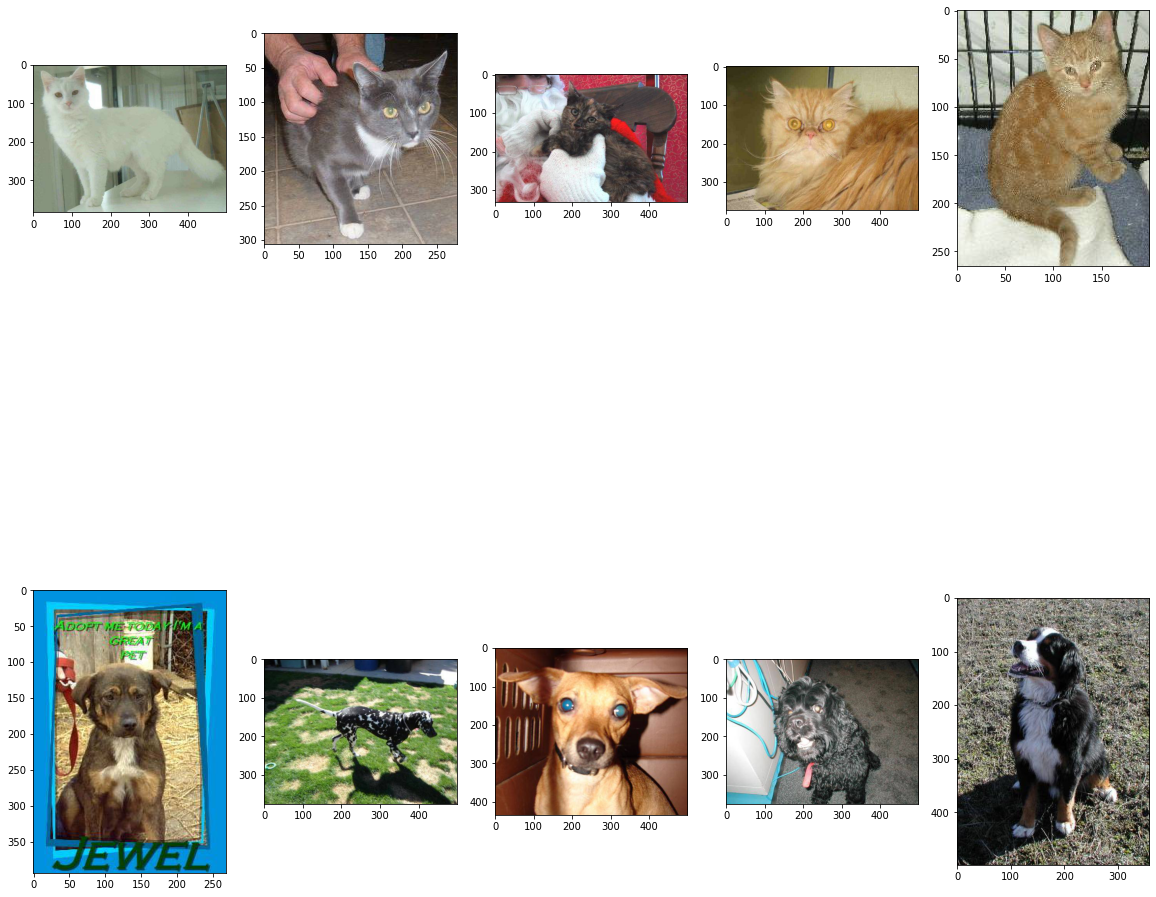

In [13]:
import random
import matplotlib.pyplot as plt

# Extract 5 random images for cats and dogs
cat_images = []
dog_images = []
while len(cat_images) != 5:
    image_name = random.choice(train_image_names)
    animal = image_name.split('.')[0]
    if animal == "cat":
        cat_images.append(os.path.join(TRAINING_DATA_DIR, image_name))

while len(dog_images) != 5:
    image_name = random.choice(train_image_names)
    animal = image_name.split('.')[0]
    if animal == 'dog':
        dog_images.append(os.path.join(TRAINING_DATA_DIR, image_name))

# One row for cats and the other for dogs
num_rows = 2
num_images = 5

figure, axes = plt.subplots(nrows=num_rows, ncols=num_images, figsize=(20,20))
for row, r_idx in zip(axes, range(0, 2)):
    # First row is for cats and second is for dogs
    if r_idx == 0:
        images_to_plot = cat_images
    else:
        images_to_plot = dog_images
    
    for column, image in zip(row, images_to_plot):
        image_data = plt.imread(image)
        column.imshow(image_data)

plt.show()

## Data Preprocessing

Set up data generators that will read pictures in the source folder, convert them to float32 tensors, and feed them (along with the labels) to our Neural Network. We need to have one generator for the training data and one for the validation data.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale all images
# Multiplying each value in the tensor by (1.0/255) is the same as dividing by 255
train_data_image_gen = ImageDataGenerator(rescale=1.0/255)
validation_data_image_gen = ImageDataGenerator(rescale=1.0/255)

# Get the actual training data generator
train_generator = train_data_image_gen.flow_from_dataframe(
    train_df,                       # The dataframe containing filenames relative to "directory"
    directory = TRAINING_DATA_DIR,  # The directory in which the training images can be found
    x_col = "image_name",           # The column within the dataframe which is to be treated as the input
    y_col = "string_label",         # The column within the dataframe which is to be treated as the output
    target_size = (150, 150),       # Each image should be of size (150, 150)
    class_mode = "binary",          # We are dealing with a binary classification problem
    batch_size = 128                # Load images in batches of size 128
)

# Get the actual validation data generator
validation_generator = validation_data_image_gen.flow_from_dataframe(
    validate_df,                    # The dataframe containing filenames relative to "directory"
    directory = TRAINING_DATA_DIR,  # The directory in which the validation images can be found
    x_col = "image_name",           # The column within the dataframe which is to be treated as the input
    y_col = "string_label",         # The column within the dataframe which is to be treated as the output
    target_size = (150, 150),       # Each image should be of size (150, 150)
    class_mode = "binary",          # We are dealing with a binary classification problem
    batch_size = 32                 # Load images in batches of size 32
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### See how the data generator works with a cat image

      image_name string_label  integer_label
0  cat.11105.jpg          cat              0

Found 1 validated image filenames belonging to 1 classes.


[]

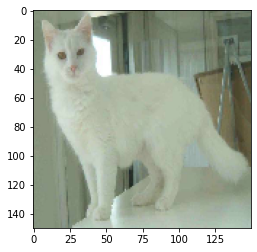

In [15]:
cat_image_name = os.path.basename(cat_images[0])
cat_example_df = train_df[train_df["image_name"] == cat_image_name]
cat_example_df = cat_example_df.reset_index(drop=True)
print (cat_example_df)
print ()

# If we set the class_mode to "binary" we see the following error - If class_mode="binary" there must be 2 classes. Found 1 classes.
sample_cat_generator = train_data_image_gen.flow_from_dataframe(
    cat_example_df,
    directory = TRAINING_DATA_DIR,
    x_col = "image_name",
    y_col = "string_label",
    target_size = (150, 150),
    class_mode = "categorical"
)

# Don't use a for-loop to iterate over the image data generator iterator - It leads to infinite loops
cat_image_data = sample_cat_generator[0][0]
# Convert image data from (1, *, *, 3) to (*, *, 3)
cat_image_data = cat_image_data.reshape(cat_image_data.shape[1], cat_image_data.shape[2], cat_image_data.shape[3])
plt.imshow(cat_image_data)
plt.plot()

### See how the data generator works with a dog image

     image_name string_label  integer_label
0  dog.8814.jpg          dog              1

Found 1 validated image filenames belonging to 1 classes.


[]

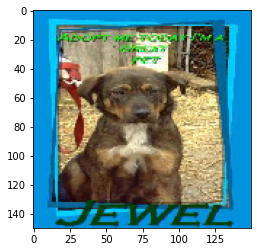

In [16]:
dog_image_name = os.path.basename(dog_images[0])
dog_example_df = train_df[train_df["image_name"] == dog_image_name]
dog_example_df = dog_example_df.reset_index(drop=True)
print (dog_example_df)
print ()

# If we set the class_mode to "binary" we see the following error - If class_mode="binary" there must be 2 classes. Found 1 classes.
sample_dog_generator = train_data_image_gen.flow_from_dataframe(
    dog_example_df,
    directory = TRAINING_DATA_DIR,
    x_col = "image_name",
    y_col = "string_label",
    target_size = (150, 150),
    class_mode = "categorical"
)

# Don't use a for-loop to iterate over the image data generator iterator - It leads to infinite loops
dog_image_data = sample_dog_generator[0][0]
# Convert image data from (1, *, *, 3) to (*, *, 3)
dog_image_data = dog_image_data.reshape(dog_image_data.shape[1], dog_image_data.shape[2], dog_image_data.shape[3])
plt.imshow(dog_image_data)
plt.plot()

## Build a Convolutional Neural Network

In [17]:
import tensorflow as tf

model = tf.keras.models.Sequential()

# Create a Convolutional layer that accepts image data in matrix form.
# This layer learns 16 filters each of size kernel_size. (In this case 3 x 3)
# The filters are used to transform the input image. (Like enhance image edges and relevant features)
# Each image being fed into the convolution has a shape of 150 x 150 and has 3 color channels
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu,
                                 input_shape=(150, 150, 3)))

# Create a MaxPool layer that looks at the transformed image 2 x 2 pixels at a time.
# This layer helps replace each 2 x 2 sub section of the image with the max pixel value found in the sub section. 
# This function effectively turns 4 pixels into 1.
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add another Convolutional and MaxPooling layer
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add another Convolutional and MaxPooling layer
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add another Convolutional and MaxPooling layer
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the transformed image data to a vector
model.add(tf.keras.layers.Flatten())

# Add a hidden layer
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))

# Compute the output using sigmoid (This is a Binary Classification Problem)
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

### Provide the optimizer and loss function

In [18]:
model.compile(optimizer = tf.optimizers.RMSprop(lr=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### Get the model summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

### Experiment with model callbacks

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Monitor validation accuracy for Early Stopping
# If validation accuracy has not increased by at least 0.01 in 3 epochs stop training
early_stopping = EarlyStopping(monitor="val_accuracy",
                               verbose=1,
                               min_delta=0.01,
                               patience=3)

# Reduce the learning rate when the accuracy has not increased for 2 epochs
# NEW LEARNING RATE = LEARNING RATE * FACTOR
# NEW LEARNING RATE cannot go lower than min_lr
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [early_stopping, learning_rate_reduction]

## Train the neural network

In [22]:
model.fit(train_generator,
          epochs=6,
          callbacks=callbacks,
          validation_data=validation_generator
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 157 steps, validate for 157 steps
Epoch 1/6
157/157 [==============================] - 138s 881ms/step - loss: 0.6927 - accuracy: 0.5853 - val_loss: 0.6194 - val_accuracy: 0.6826
Epoch 2/6
157/157 [==============================] - 136s 864ms/step - loss: 0.5798 - accuracy: 0.6913 - val_loss: 0.5269 - val_accuracy: 0.7334
Epoch 3/6
157/157 [==============================] - 133s 844ms/step - loss: 0.5037 - accuracy: 0.7542 - val_loss: 0.4422 - val_accuracy: 0.8018
Epoch 4/6
157/157 [==============================] - 145s 926ms/step - loss: 0.4377 - accuracy: 0.7969 - val_loss: 0.4105 - val_accuracy: 0.8156
Epoch 5/6
157/157 [==============================] - 154s 982ms/step - loss: 0.3880 - accuracy: 0.8242 - val_loss: 0.3651 - val_accuracy: 0.8348
Epoch 6/6
157/157 [==============================] - 154s 979ms/step - loss: 0.3434 - accuracy: 0.8490 - val_loss: 0.4034 - val_accuracy: 0.8172


### Evaluate the Neural Network on the validation dataset

In [23]:
model.evaluate(validation_generator)

  ...
    to  
  ['...']
157/157 [==============================] - 15s 95ms/step - loss: 0.4034 - accuracy: 0.8172


[0.4033879650056742, 0.8172]

## Visualizing the convolutions and pooling

In [24]:
# Get the output of each layer to help visualize the convolutions
layer_outputs = [layer.output for layer in model.layers]
model_for_visualization = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

In [25]:
# Get one image of each class from the training data
train_batch = next(train_generator)
input_data = train_batch[0]
output_data = train_batch[1]
cat_img = None
dog_img = None
for input_, output_ in zip(input_data, output_data):
    if cat_img is not None and dog_img is not None:
        break
        
    if output_ == 0:
        cat_img = input_
    else:
        dog_img = input_

### Visualize cat

In [26]:
cat_prediction = model_for_visualization.predict(cat_img.reshape(1, 150, 150, 3))

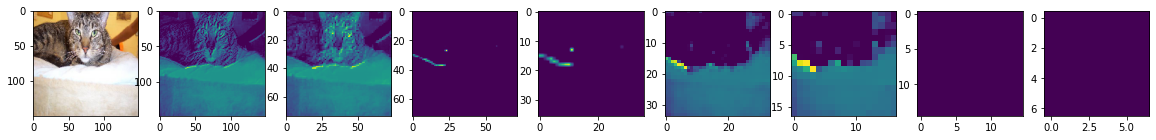

In [28]:
# Display CONVOLUTION = 5 (out of 16/64/128 possible convolutions)
CONVOLUTION = 5

# nrows = 1 (One for each image)
# ncols = 9 (One column for the input, 8 for visualizing a random convolution (aka filter) and pooling)
figure, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 20))
for column, c_idx in zip(axes, range(0, 9)):
    # Display the actual image
    if c_idx == 0:
        column.imshow(cat_img)
        
    # Display CONVOLUTION learnt at the first Conv2D layer
    elif c_idx == 1:
        column.imshow(cat_prediction[0][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 2:
        column.imshow(cat_prediction[1][0, : , : , CONVOLUTION])
    
    # Display CONVOLUTION learnt at the second Conv2D layer
    elif c_idx == 3:
        column.imshow(cat_prediction[2][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 4:
        column.imshow(cat_prediction[3][0, : , : , CONVOLUTION])
    
    # Display CONVOLUTION learnt at the third Conv2D layer
    elif c_idx == 5:
        column.imshow(cat_prediction[4][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 6:
        column.imshow(cat_prediction[5][0, : , : , CONVOLUTION])
    
    # Display CONVOLUTION learnt at the fourth Conv2D layer
    elif c_idx == 7:
        column.imshow(cat_prediction[6][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 8:
        column.imshow(cat_prediction[7][0, : , : , CONVOLUTION])

### Visualize dog

In [29]:
dog_prediction = model_for_visualization.predict(dog_img.reshape(1, 150, 150, 3))

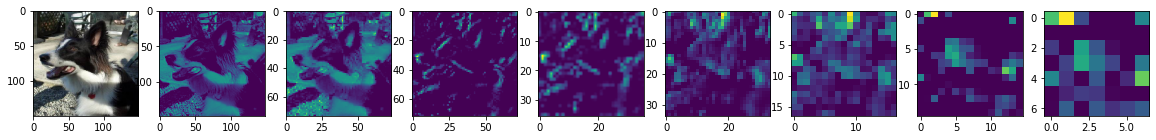

In [30]:
# Display CONVOLUTION = 10 (out of 16/64/128 possible convolutions)
CONVOLUTION = 10

# nrows = 1 (One for each image)
# ncols = 9 (One column for the input, 8 for visualizing a random convolution (aka filter) and pooling)
figure, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 20))
for column, c_idx in zip(axes, range(0, 9)):
    # Display the actual image
    if c_idx == 0:
        column.imshow(dog_img)
        
    # Display CONVOLUTION learnt at the first Conv2D layer
    elif c_idx == 1:
        column.imshow(dog_prediction[0][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 2:
        column.imshow(dog_prediction[1][0, : , : , CONVOLUTION])
    
    # Display CONVOLUTION learnt at the second Conv2D layer
    elif c_idx == 3:
        column.imshow(dog_prediction[2][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 4:
        column.imshow(dog_prediction[3][0, : , : , CONVOLUTION])
    
    # Display CONVOLUTION learnt at the third Conv2D layer
    elif c_idx == 5:
        column.imshow(dog_prediction[4][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 6:
        column.imshow(dog_prediction[5][0, : , : , CONVOLUTION])
    
    # Display CONVOLUTION learnt at the fourth Conv2D layer
    elif c_idx == 7:
        column.imshow(dog_prediction[6][0, : , : , CONVOLUTION])
    
    # Display MAX_POOLING effect
    elif c_idx == 8:
        column.imshow(dog_prediction[7][0, : , : , CONVOLUTION])

## Make some random predictions on test data

In [31]:
test_image_names = ["1.jpg", "5.jpg"]
test_string_labels = ["dog", "cat"]
test_integer_labels = [1, 0]

test_df = pd.DataFrame({
    'image_name' : test_image_names,
    'string_label' : test_string_labels,
    'integer_label' : test_integer_labels
})

### Get test examples count

In [32]:
test_df.count()

image_name       2
string_label     2
integer_label    2
dtype: int64

### Look at the test dataframe head

In [33]:
test_df.head()

,image_name,string_label,integer_label
0,1.jpg,dog,1
1,5.jpg,cat,0


### Data Preprocessing

In [34]:
# Rescale all images
# Multiplying each value in the tensor by (1.0/255) is the same as dividing by 255
test_data_image_gen = ImageDataGenerator(rescale=1.0/255)

# Get the actual training data generator
test_generator = test_data_image_gen.flow_from_dataframe(
    test_df,                     # The dataframe containing filenames relative to "directory"
    directory = TEST_DATA_DIR,   # The directory in which the training images can be found
    x_col = "image_name",        # The column within the dataframe which is to be treated as the input
    y_col = "string_label",      # The column within the dataframe which is to be treated as the output
    target_size = (150, 150),    # Each image should be of size (150, 150)
    class_mode = "binary",       # We are dealing with a binary classification problem
    batch_size = 128             # Load images in batches of size 128
)

Found 2 validated image filenames belonging to 2 classes.


### Evaluate the Neural Network on the test dataset

In [35]:
model.evaluate(test_generator)

  ...
    to  
  ['...']
1/1 [==============================] - 0s 29ms/step - loss: 0.0583 - accuracy: 1.0000


[0.05832274630665779, 1.0]

### Get the predictions

In [36]:
model_predictions = model.predict(test_generator)

for idx, truth_label, model_label in zip(range(0, 2), test_integer_labels, model_predictions):
    print ("Image {}, Truth Label {}, Model Prediction {}".format(idx, truth_label, model_label))

Image 0, Truth Label 1, Model Prediction [0.9539759]
Image 1, Truth Label 0, Model Prediction [0.06716664]
